# Enhancing Gradient Descent

In this notebook we show how standardising data and the Adam optimiser can help gradient descent converge faster. We use Linear Regression instead of a Neural Network, so we can visualise the shape of the loss and the path Gradient Descent takes until the loss minimum.

In [1]:
import keras
from keras.models import Sequential
from tensorflow.keras import regularizers, initializers
from keras.layers import Dense
from keras import backend as K
from keras.callbacks import Callback
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import itertools
import os

2025-06-21 16:32:24.317583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 16:32:24.326957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750519944.337374  255858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750519944.340638  255858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-21 16:32:24.352995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size": 14,
    "figure.dpi": 300})

## Generating the data set

In [3]:
train_size = 1000

X_func = np.linspace(0, 10, 1001, endpoint=True)
y_func = 2 * X_func + 2

In [4]:
X_train = np.linspace(0, 10, train_size, endpoint=True)

## Uncomment to generate new random observations of training data
#y_train = (2 * X_train + 2 + np.random.normal(scale=2.0, size=train_size)).T
#np.savetxt('InputData/GradDesc-y_train.dat', y_train)

y_train = np.loadtxt('InputData/GradDesc-y_train.dat').reshape(-1,1)

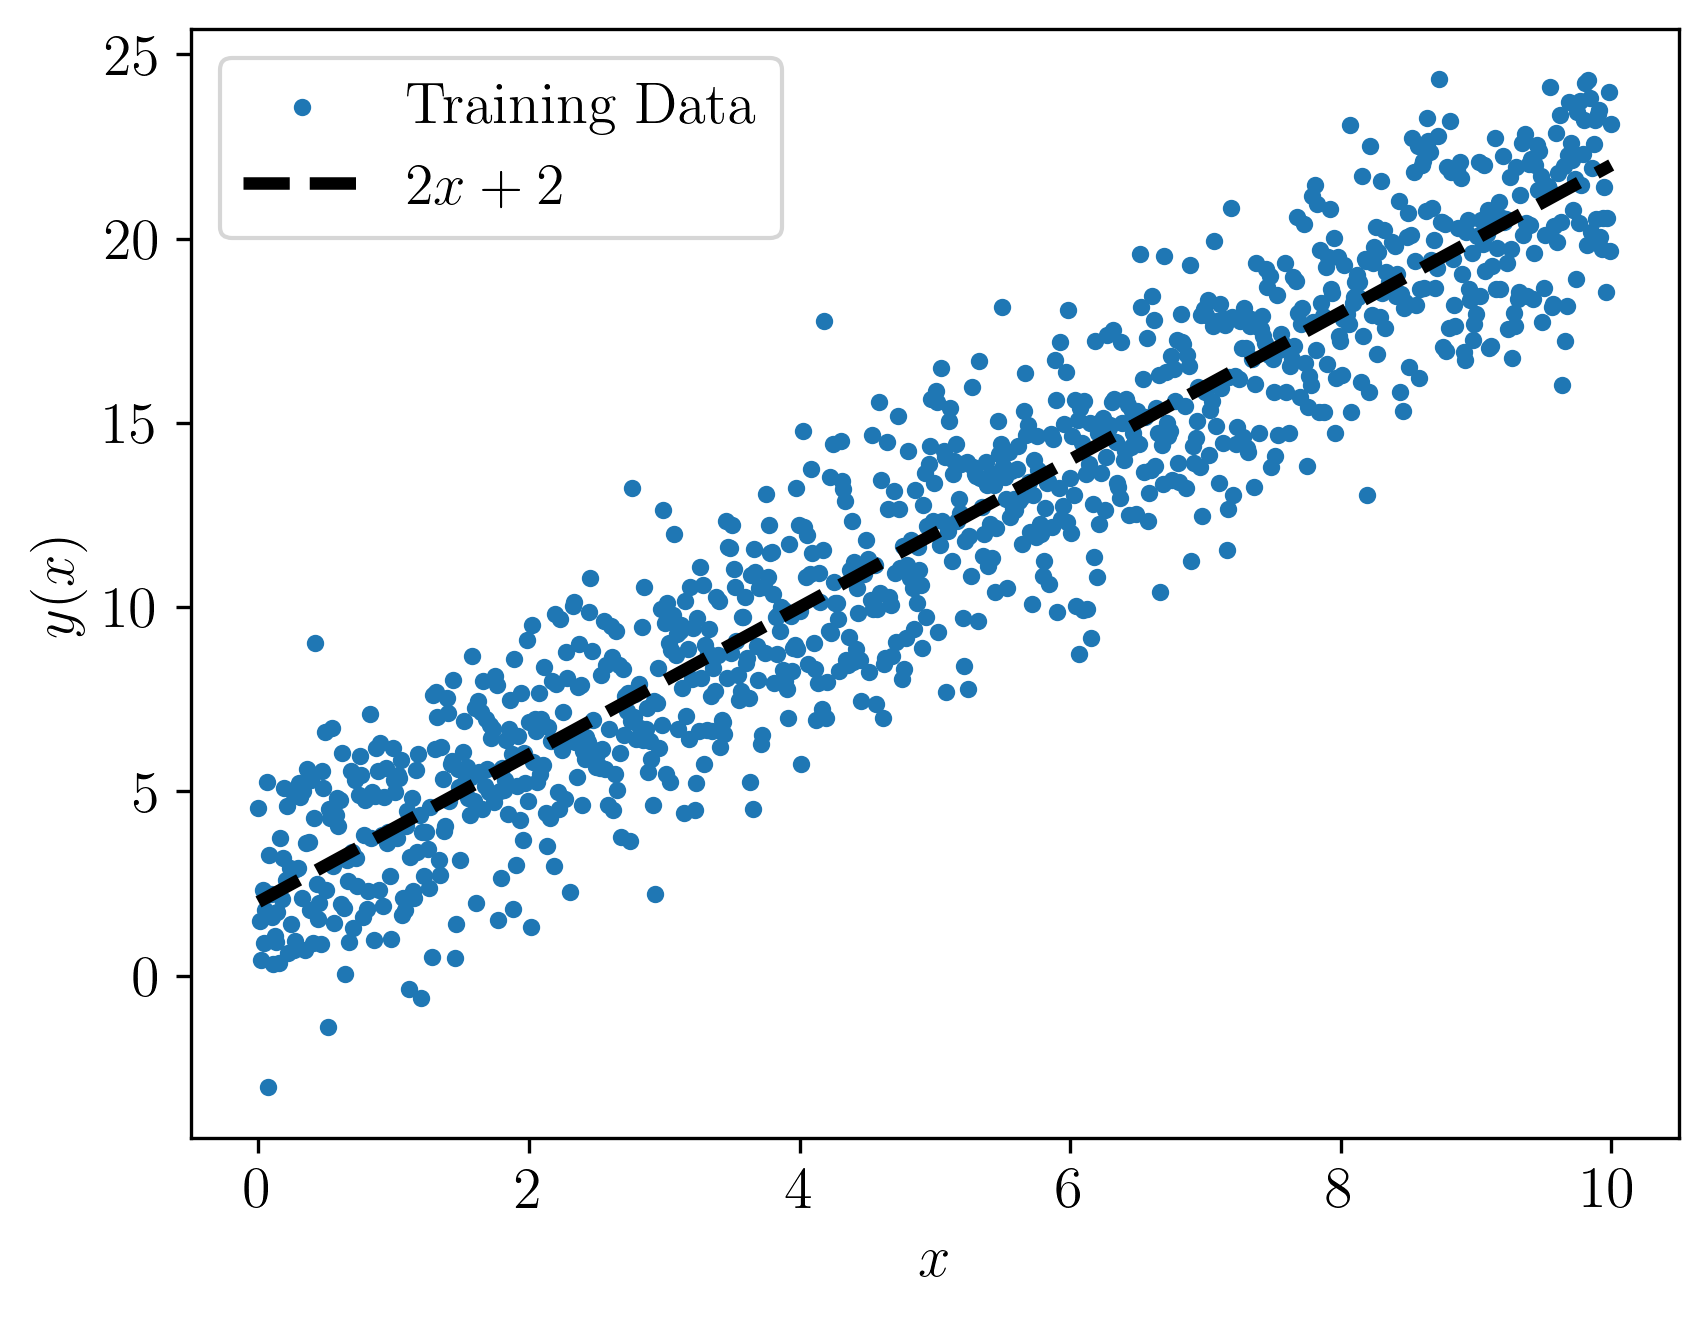

In [5]:
plt.scatter(x=X_train, y=y_train, s=10, marker="o")
plt.plot(X_func, y_func, linewidth=3, linestyle='dashed', color='black')
plt.xlabel(r'$x$')
plt.ylabel(r'$y(x)$')
plt.legend(['Training Data', r'$2x + 2$'])
plt.savefig('Plots/GradDesc-data.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

## Callback to save weights during training

In [6]:
class WeightsHistory(tf.keras.callbacks.Callback):
    """
    A callback designed to save weights in a list after every single update.
    """
    def __init__(self):
        super().__init__()
        self.weights_history = []

    def on_train_batch_end(self, batch, logs=None):
        current_weights = [w.numpy().copy().item() for w in self.model.trainable_weights]
        self.weights_history.append(current_weights)

## Some functions

In [7]:
def build_model(optimizer, start_w, start_b):
    """
    Builds a linear regression model with a custom starting point.

    Args:
        optimizer: Optimizer to train the model.
        start_w (float): Starting weight.
        start_b (float): Starting bias.

    Returns:
        model
    """
    model=Sequential()
    mse = tf.keras.losses.MeanSquaredError()
    model.add(Dense(1, activation='linear', input_dim=1, kernel_initializer=initializers.Constant([start_w]), bias_initializer=initializers.Constant([start_b])))
    model.compile(loss=mse, optimizer=optimizer, metrics=["mean_squared_error"])
    return model

In [8]:
# Specifically created for plotting.
def MSE(x, y_true, weights):
    """
    Computes the mean squared error (MSE).

    Args:
        x (float): Point of the domain.
        y_true (float): The true value of y associated with x.
        weights (float, float): Weight of x and bias terms.

    Returns:
        L (float): Value of MSE loss for point (x, y).
    """
    b, w = weights 
    y_pred = x * w + b 
    L = 0.5 * np.mean((y_true - y_pred)**2)
    return L

In [9]:
def plot_contour(f, b_bound, w_bound, resolution, fig, ax):
    """
    Comprises a few settings to draw the contour plots of the MSE loss function.

    Args:
        f: Loss function.
        b_bound (float, float): Range of the bias term b for plotting.
        w_bound (float, float): Range of the weight w for plotting.
        resolution (int): Number of points in a dimension of the meshgrid.
        fig: matplotlib Figure instance.
        ax: matplotlib Axes instance.

    Returns:
        fig: matplotlib Figure instance.
        ax: matplotlib Axes instance.
    """
    b_range = np.linspace(b_bound[0], b_bound[1], resolution)
    w_range = np.linspace(w_bound[0], w_bound[1], resolution)
    xg, yg = np.meshgrid(b_range, w_range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    print(zg.shape)
    cs = ax.contourf(xg, yg, zg, 20)
    fig.colorbar(cs)
    return fig, ax

## Training and results

### Batch gradient descent + Non-standardised data

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.025)
model = build_model(opt, -10, -10)
model.summary()

I0000 00:00:1750519946.280311  255858 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9602 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/joao/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
weights_callback = WeightsHistory()
batch_size = 1000
epochs = 500 
hist=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[weights_callback])

Epoch 1/500


I0000 00:00:1750519946.523046  255949 service.cc:148] XLA service 0x74f530004820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750519946.523069  255949 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
I0000 00:00:1750519946.535519  255949 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 6384.3223 - mean_squared_error: 6384.3223
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3189.4907 - mean_squared_error: 3189.4907
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1600.1201 - mean_squared_error: 1600.1201
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 809.2974 - mean_squared_error: 809.2974
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 415.6723 - mean_squared_error: 415.6723
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 219.6163 - mean_squared_error: 219.6163

I0000 00:00:1750519946.604661  255949 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 219.6163 - mean_squared_error: 219.6163
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 121.8360 - mean_squared_error: 121.8360
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 72.9435 - mean_squared_error: 72.9435
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 48.3736 - mean_squared_error: 48.3736
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 35.9077 - mean_squared_error: 35.9077
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.4681 - mean_squared_error: 29.4681
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.0319 - mean_squared_error: 26.0319
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 24.0951 - mean_squared_error: 24.0951
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 22.9096 - mean_squared_error: 22.9096
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 22.1033 - mean_squared_error: 22.1033
Epoch 16/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [12]:
weights = np.asarray(weights_callback.weights_history)
weights = np.vstack([[-10, -10], weights]) #Starting point for the weight and bias
print(weights[-1]) #Confirming that gradient descent ended approximately at w=b=2.

[1.99112177 2.01364732]


(200, 200)


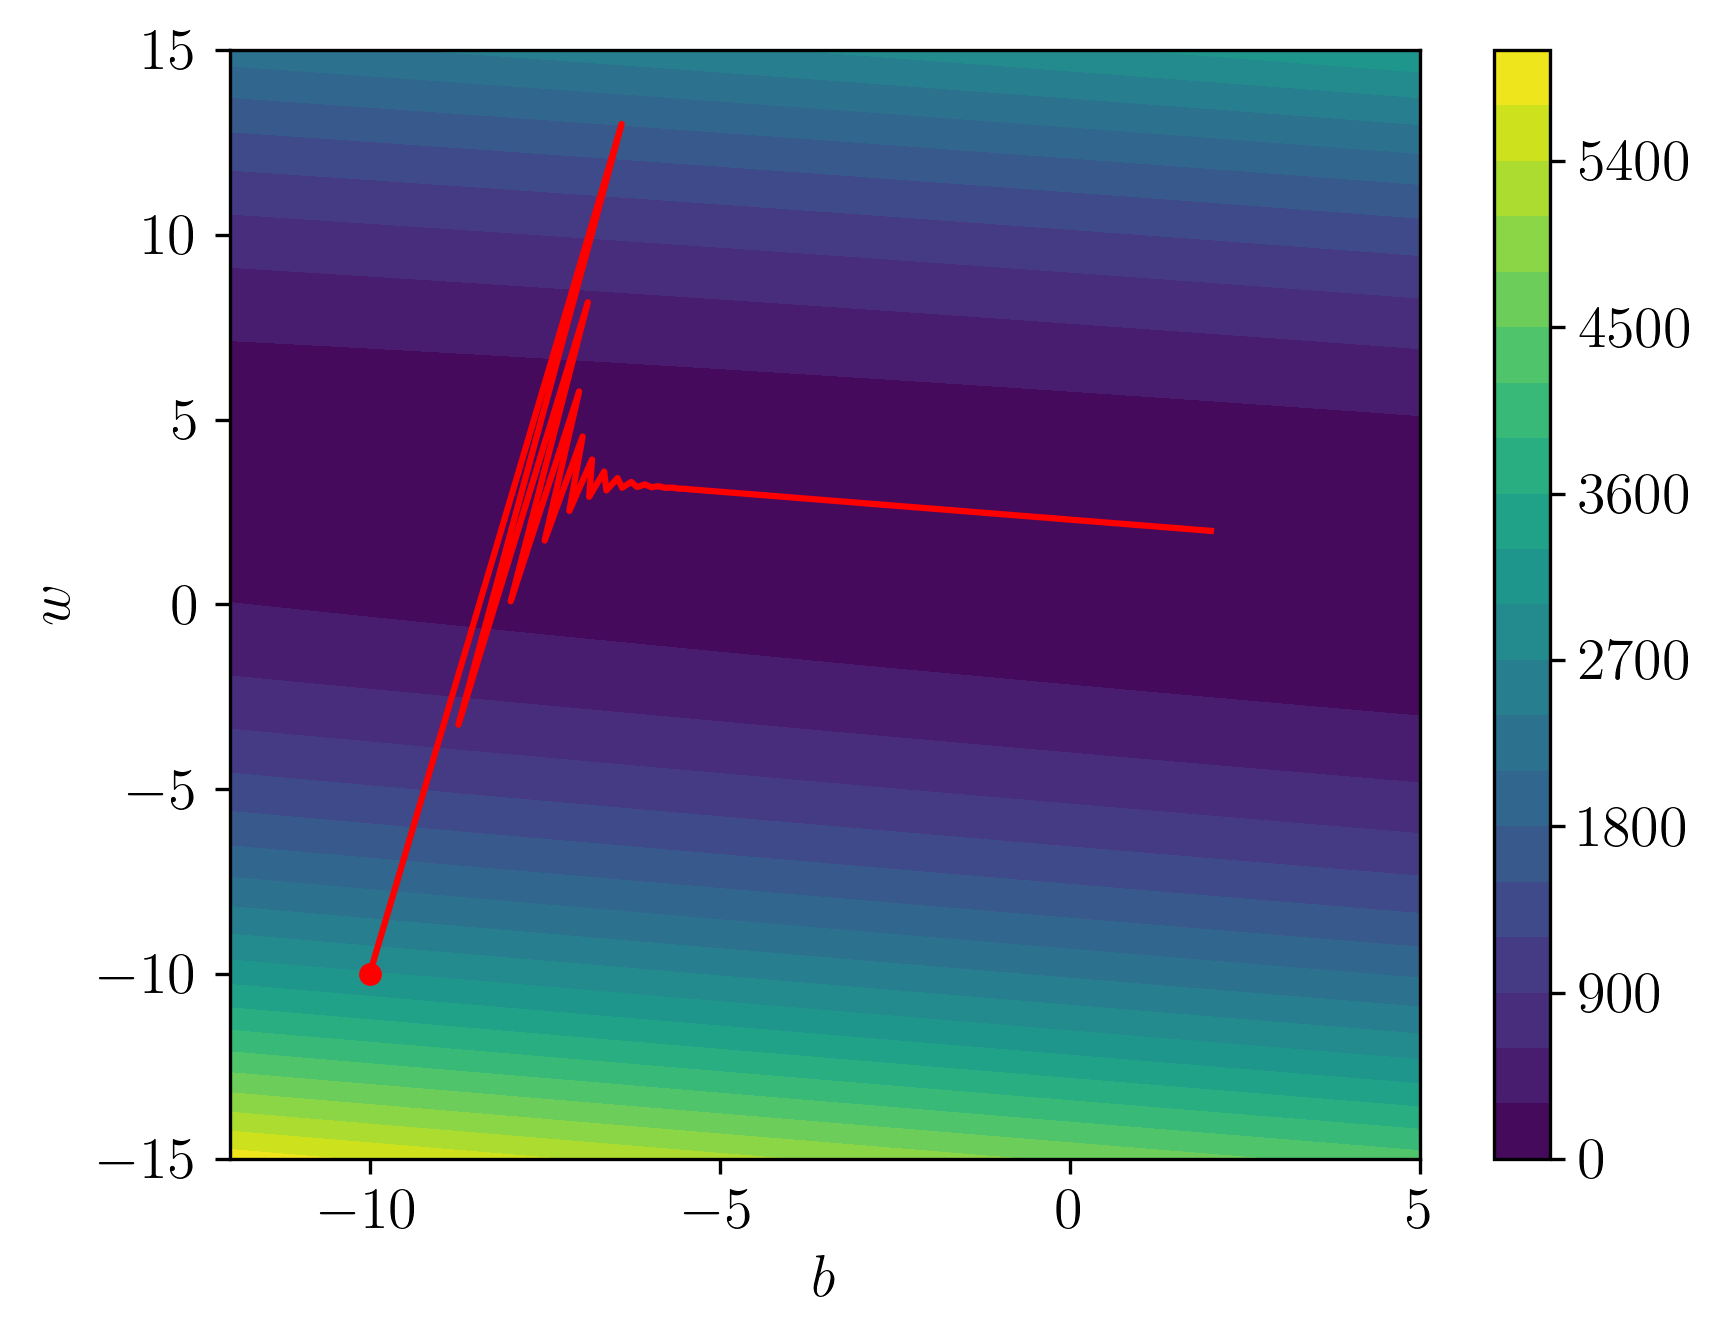

In [13]:
cost_w = lambda param: MSE(X_train, y_train, param) #Define the cost just as a function of parameters (w and b).
fig, axes = plt.subplots()
plot_contour(cost_w, [-12,5], [-15,15], 200, fig, axes)
axes.set_xlabel(r'$b$')
axes.set_ylabel(r'$w$')
plt.plot(weights[:,1], weights[:,0], color='r', markersize=5)
plt.scatter([-10], [-10], s=20, color='red')
plt.savefig('Plots/GradDesc-BGD_NoSt.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

### Batch gradient descent + Standardised data

In [14]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train.reshape(-1,1))
print(scaler.mean_, np.sqrt(scaler.var_))

[5.] [2.88963954]


In [15]:
#Solve in order to w and b the equation y = w * (x - mean) / std + b for two values of x and y = 2x + 2. For example, we used the points (0,2) and (10,22).
new_w = (2.0 * np.sqrt(scaler.var_)).item()
new_b = (2.0 + 2.0 * scaler.mean_).item()
print(new_w, new_b)

5.779279084228419 11.999999999999998


In [16]:
opt = keras.optimizers.SGD(learning_rate=0.25)
model = build_model(opt, new_w - 12, new_b - 12) #We change the starting point, so gradient descent starts at the same distance as in the non-standardised case.
model.summary()

/home/joao/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
weights_callback = WeightsHistory()
batch_size = 1000
epochs = 12 
hist=model.fit(X_train_std, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[weights_callback])

Epoch 1/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 290.5703 - mean_squared_error: 290.5703
Epoch 2/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 75.6570 - mean_squared_error: 75.6570
Epoch 3/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.9287 - mean_squared_error: 21.9287
Epoch 4/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.4966 - mean_squared_error: 8.4966
Epoch 5/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.1386 - mean_squared_error: 5.1386
Epoch 6/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.2991 - mean_squared_error: 4.2991
Epoch 7/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.0892 - mean_squared_error: 4.0892
Epoch 8/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.0367 - mean_squared_error: 4.0367
Epoch 9/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0236 - mean_squared_error: 4.0236
Epoch 10/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0203 - mean_squared_error: 4.0203
Epoch 11/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.

In [18]:
weights = np.asarray(weights_callback.weights_history)
weights = np.vstack([[new_w - 12, new_b - 12], weights])
print(weights[-1]) #Confirming that gradient descent ended approximately at new_w and new_b.

[ 5.74147463 11.97150993]


(200, 200)


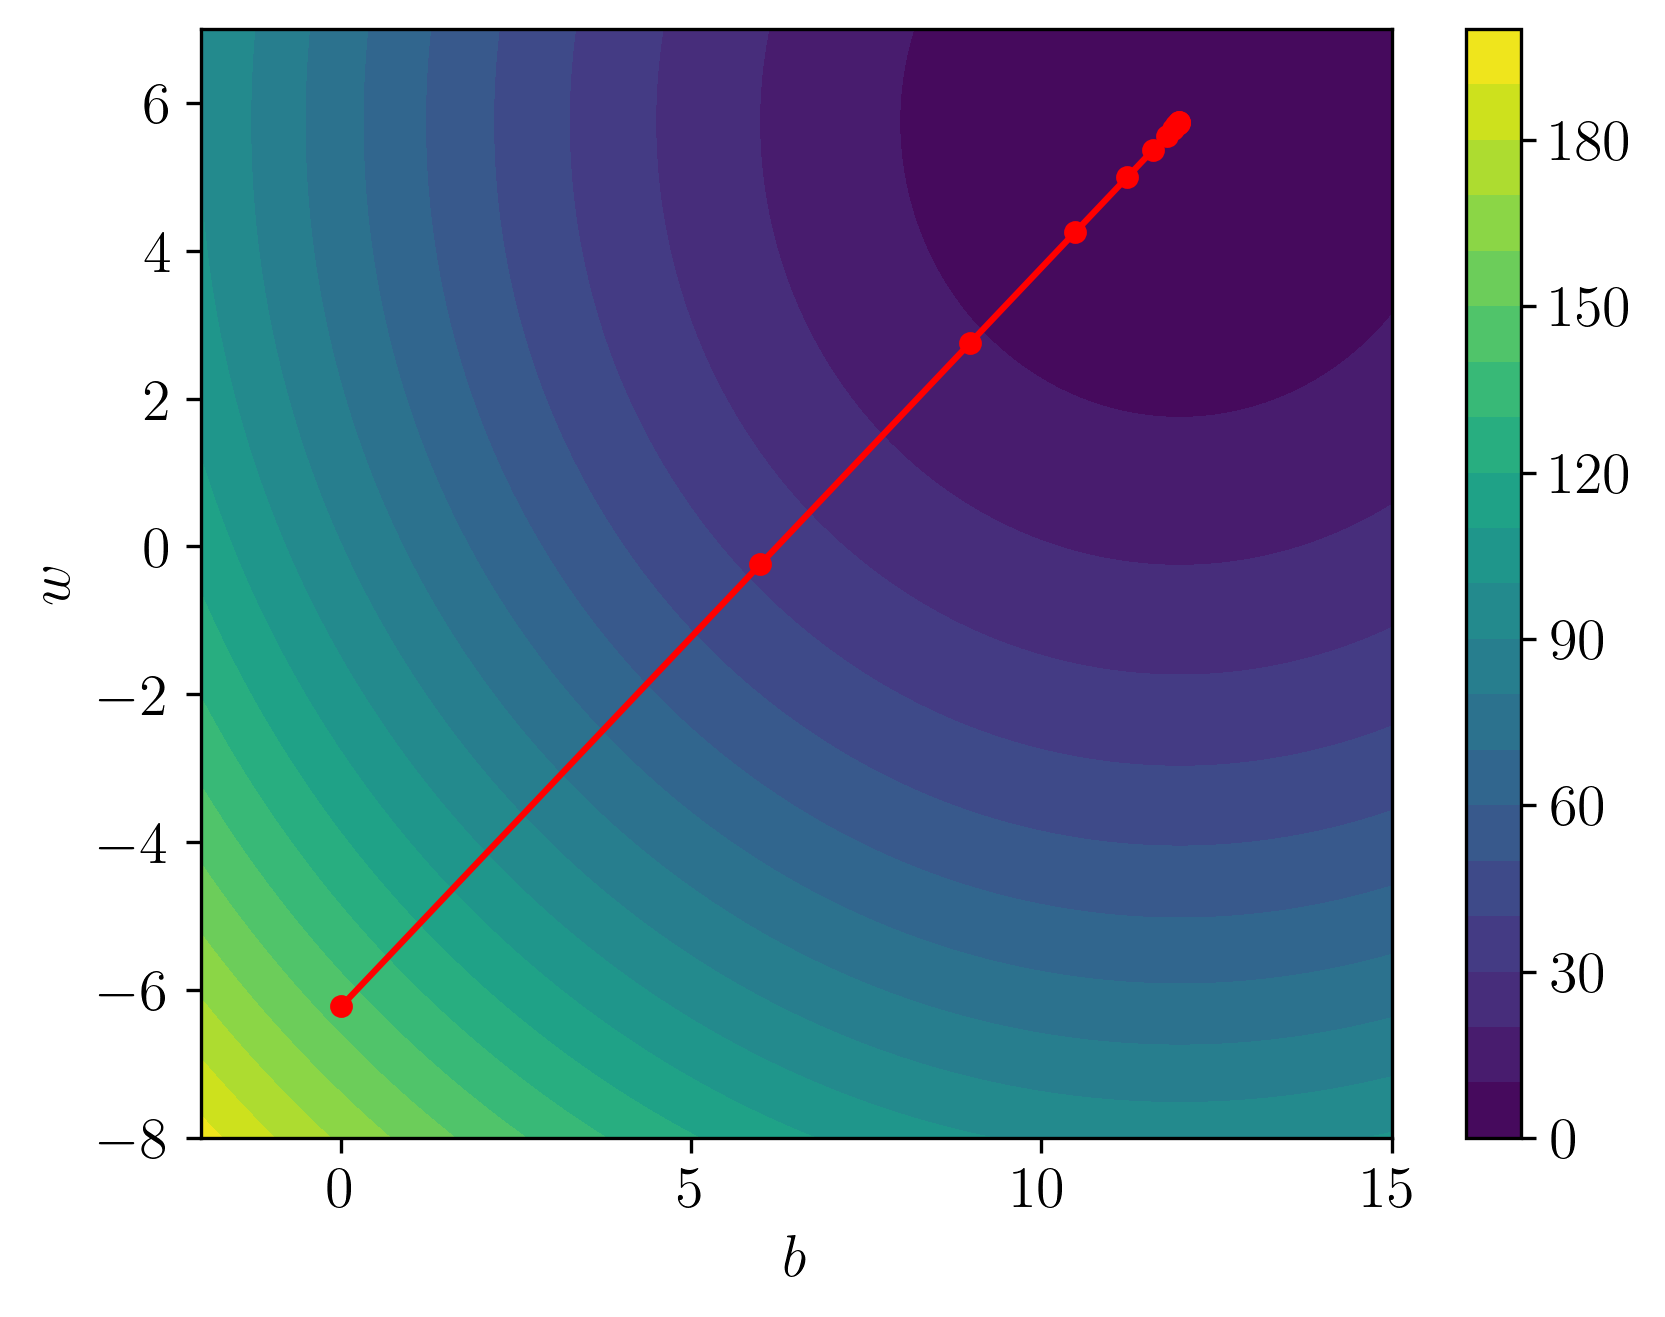

In [19]:
cost_w = lambda param: MSE(X_train_std, y_train, param) #Define the cost just as a function of parameters (w and b).
fig, axes = plt.subplots()
plot_contour(cost_w, [-2,15], [-8,7], 200, fig, axes)
axes.set_xlabel(r'$b$')
axes.set_ylabel(r'$w$')
plt.plot(weights[:,1], weights[:,0], color='r', markersize=5)
plt.scatter([weights[:,1]], [weights[:,0]], s=20, color='red')
plt.savefig('Plots/GradDesc-BGD_St.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

### Stochastic gradient descent + Standardised data

In [20]:
opt = keras.optimizers.SGD(learning_rate=0.005)
model = build_model(opt, new_w - 12, new_b - 12) #We change the starting point, so gradient descent starts at the same distance as in the non-standardised case.
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
weights_callback = WeightsHistory()
batch_size = 1
epochs = 2 
hist=model.fit(X_train_std, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[weights_callback])

Epoch 1/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - loss: 51.0147 - mean_squared_error: 51.0147
Epoch 2/2
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - loss: 4.1776 - mean_squared_error: 4.1776


In [22]:
weights = np.asarray(weights_callback.weights_history)
weights = np.vstack([[new_w - 12, new_b - 12], weights])
print(weights[-1]) #Confirming that gradient descent ended approximately at new_w and new_b.

[ 5.71897221 11.95394707]


(200, 200)


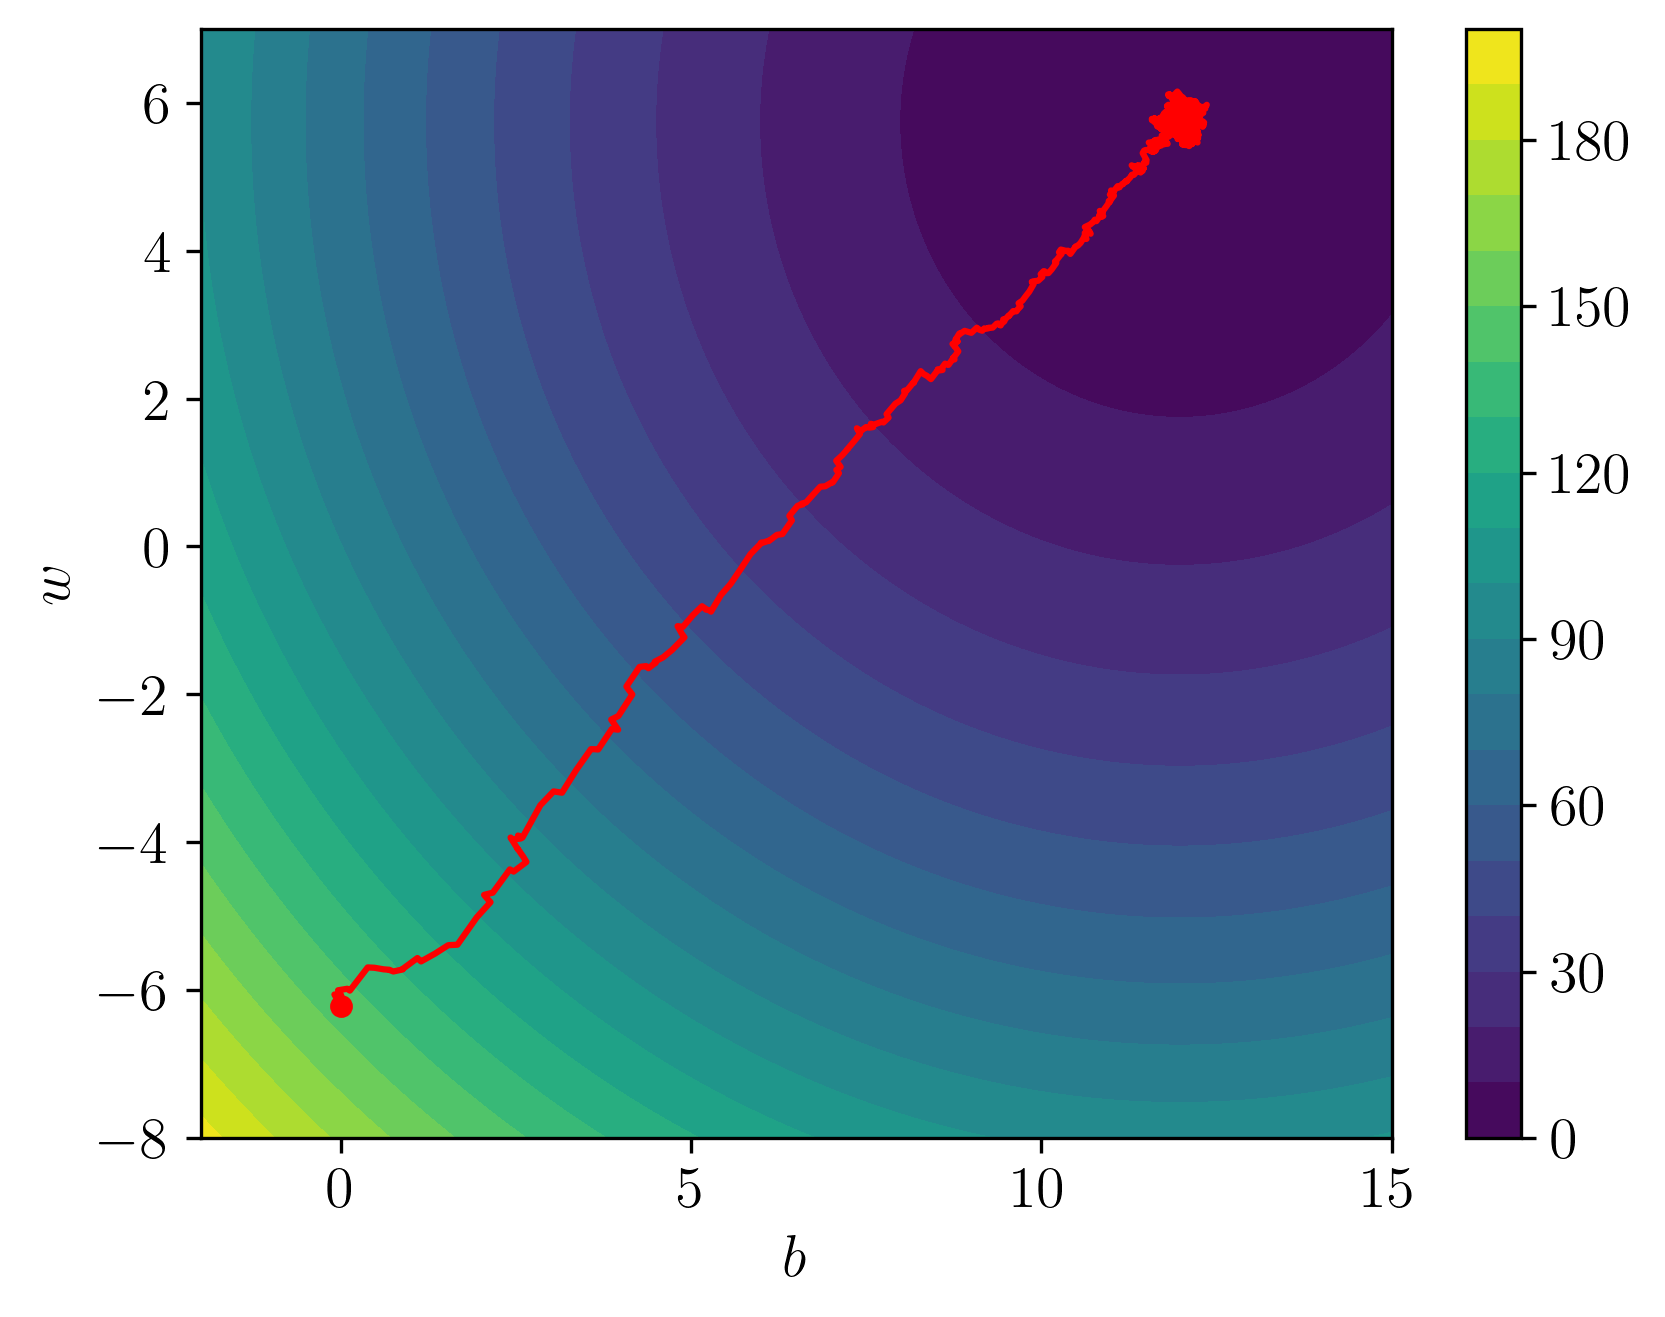

In [23]:
cost_w = lambda param: MSE(X_train_std, y_train, param) #Define the cost just as a function of parameters (w and b).
fig, axes = plt.subplots()
plot_contour(cost_w, [-2,15], [-8,7], 200, fig, axes)
axes.set_xlabel(r'$b$')
axes.set_ylabel(r'$w$')
plt.plot(weights[:,1], weights[:,0], color='r', markersize=5)
plt.scatter([new_b - 12], [new_w - 12], s=20, color='red')
plt.savefig('Plots/GradDesc-SGD_St.png', bbox_inches='tight', pad_inches=0.01)
plt.show()

### Adam + Standardised data

In [24]:
opt = keras.optimizers.Adam(learning_rate=0.25)
model = build_model(opt, new_w - 12, new_b - 12) #We change the starting point, so gradient descent starts at the same distance as in the non-standardised case.
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
weights_callback = WeightsHistory()
batch_size = 10
epochs = 2 
hist=model.fit(X_train_std, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[weights_callback])

Epoch 1/2
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 149.5096 - mean_squared_error: 149.5096
Epoch 2/2
  1/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6876 - mean_squared_error: 5.6876

2025-06-21 16:33:06.122160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 4.0182 - mean_squared_error: 4.0182


In [26]:
weights = np.asarray(weights_callback.weights_history)
weights = np.vstack([[new_w - 12, new_b - 12], weights])
print(weights[-1]) #Confirming that gradient descent ended approximately at new_w and new_b.

[ 5.6878376  12.02130508]


(200, 200)


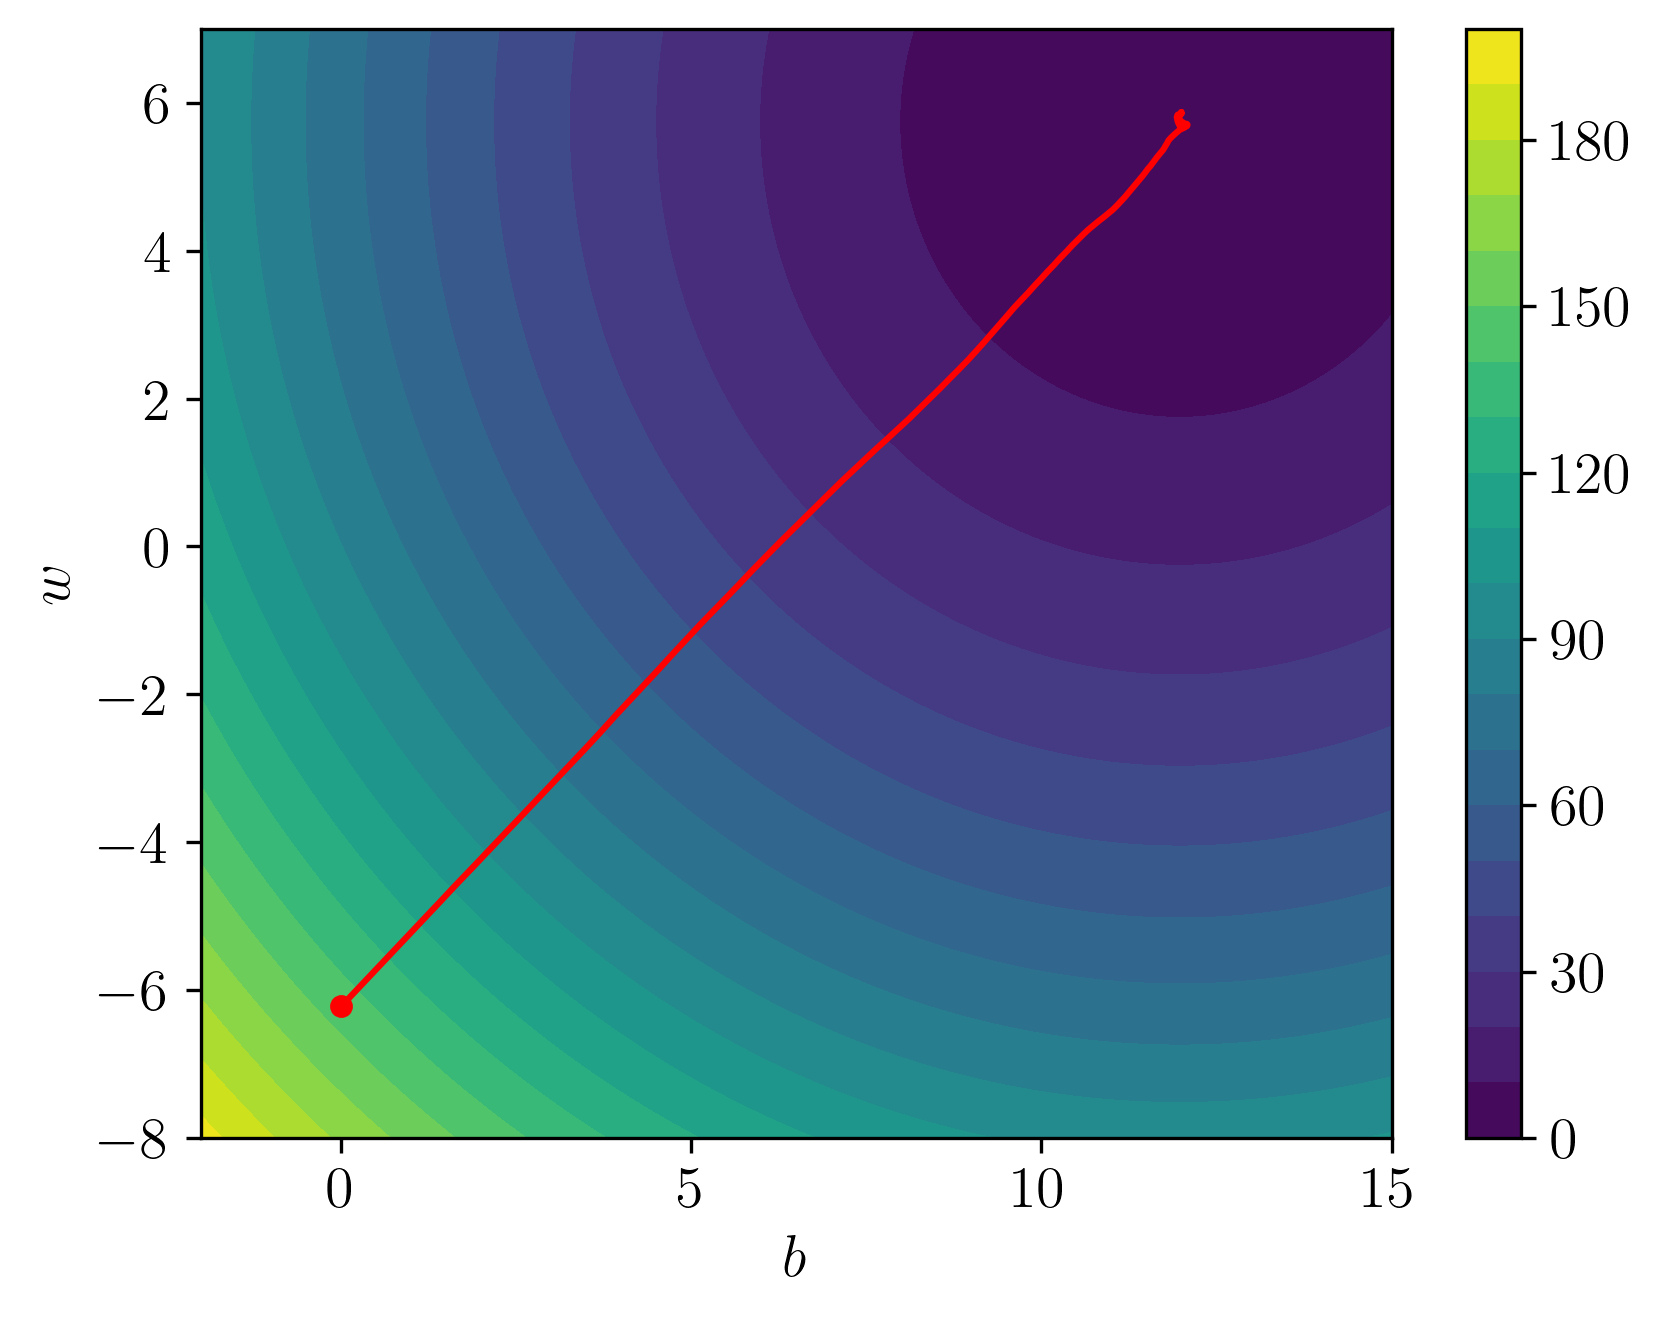

In [27]:
cost_w = lambda param: MSE(X_train_std, y_train, param) #Define the cost just as a function of parameters (w and b).
fig, axes = plt.subplots()
plot_contour(cost_w, [-2,15], [-8,7], 200, fig, axes)
axes.set_xlabel(r'$b$')
axes.set_ylabel(r'$w$')
plt.plot(weights[:,1], weights[:,0], color='r', markersize=5)
plt.scatter([new_b - 12], [new_w - 12], s=20, color='red')
plt.savefig('Plots/GradDesc-Adam_St.png', bbox_inches='tight', pad_inches=0.01)
plt.show()